# 1) 영상으로부터 신호 pickle 파일 생성하기

In [5]:
import glob
import os
import cv2
import numpy as np
from scipy.fftpack import fft

# srcPath = "E:/FingerveinSpoofingDB/samples"
srcPath = "F:\\Finger_vein_Database\\abc"
dstPath = "pickle_1"

lenSignal = 150
lenOverlap = 50

listOfFiles = glob.glob(os.path.join(srcPath,"*/*/*.avi"))  # 경로 설정, 파일 지정
print(len(listOfFiles))
print('===========================================================================')

trainDict = {}  # {} 타입으로 Dictionary 선언 {"key" : value} 방식 사용
testDict = {}

train_listOfSignals = []   # [] 타입으로 Array 선언 / * 주의: ()는 tuple에서 사용 (튜플은 값이나 길이 변경 불가능)
train_listOfFrequencies = []
train_listOfClasses = []

test_listOfSignals = []
test_listOfFrequencies = []
test_listOfClasses = []

veriDict = {1:[], -1:[]}

for i, filePath in enumerate(listOfFiles):  # enumerate를 이용해서 순서가 있는 자료형을 입력으로 받아 인덱스, 값 반환
    print(i)
    subject = int(os.path.dirname(filePath).split('\\')[-1])  # \\ 기준으로 경로 쪼개서 파일명 바로 상위 디렉터리 (\\ == /)
    print("subject: ", subject)
    label = os.path.dirname(filePath).split('\\')[-2]  # \\ 기준으로 경로 쪼개서 레이블 디렉터리 (Real or Fake)
    print("label: ", label)
    
    cap = cv2.VideoCapture(filePath)
    nFrame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if int(cap.get(cv2.CAP_PROP_FPS)) != 30:
        #비디오캡처 프레임속도 제한
        print('[ERROR] FPS is {}'.fotmat(int(cap.get(cv2.CAP_PROP_FPS))))
        break

    listOfValues = []
    while True:
        ret, frame = cap.read() # 재생되는 비디오의 한 프레임을 읽어온다. 제대로 읽어왔다면 ret=True, 그렇지않으면 False
        if ret is False:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        listOfValues.append(np.mean(gray))
    
    if label == 'real':
        labelVal = 1
    else:
        labelVal = -1
    
    s = 0
    count=0
    while s+lenSignal < nFrame:
        signal = listOfValues[s:s+lenSignal] - np.mean(listOfValues[s:s+lenSignal])
        padded = np.pad(signal, (0, 9*len(signal)), 'constant')# 왼쪽0 오른쪽 ? 만큼 패딩
        #print(type(padded))
        frequency = fft(padded)
        frequency = np.abs(frequency[:len(padded)//2])
#         frequency /= np.max(frequency)
        count+=1
        if subject <= 10:                       
            train_listOfSignals.append(signal)
            train_listOfFrequencies.append(frequency)
            train_listOfClasses.append([labelVal])
        else:
            test_listOfSignals.append(signal)
            test_listOfFrequencies.append(frequency)
            test_listOfClasses.append([labelVal])
            
        s += lenOverlap
    print("COUNT",count)
trainDict['timedomain'] = np.array(train_listOfSignals).astype(np.float32)
trainDict['freqdomain'] = np.array(train_listOfFrequencies).astype(np.float32)
trainDict['label'] = np.array(train_listOfClasses).astype(np.int32)

testDict['timedomain'] = np.array(test_listOfSignals).astype(np.float32)
testDict['freqdomain'] = np.array(test_listOfFrequencies).astype(np.float32)
testDict['label'] = np.array(test_listOfClasses).astype(np.int32)


# import pickle
# with open(os.path.join(dstPath, 'train.test'), mode='wb') as f:
#     pickle.dump(trainDict, f, protocol=4)
#     print("'train.p4' is created!!'")
    
# with open(os.path.join(dstPath, 'test.test'), mode='wb') as f:
#     pickle.dump(testDict, f, protocol=4)
#     print("'test.p4' is created!!'")

160
0
subject:  1
label:  fake
COUNT 8
1
subject:  1
label:  fake
COUNT 7
2
subject:  1
label:  fake
COUNT 8
3
subject:  1
label:  fake
COUNT 7
4
subject:  10
label:  fake
COUNT 7
5
subject:  10
label:  fake
COUNT 7
6
subject:  10
label:  fake
COUNT 7
7
subject:  10
label:  fake
COUNT 7
8
subject:  11
label:  fake
COUNT 7
9
subject:  11
label:  fake
COUNT 7
10
subject:  11
label:  fake
COUNT 7
11
subject:  11
label:  fake


KeyboardInterrupt: 

# 2) 데이터 불러오기

In [34]:
import os
import pickle

print('>> train')
with open('pickle_1/train.p4', mode='rb') as f:
    trainDict = pickle.load(f)

train_X = trainDict['freqdomain']
train_y = trainDict['label'].ravel()
print(train_X.shape)
print(train_y.shape)

print()
print('>> test')
with open('pickle_1/test.p4', mode='rb') as f:
    testDict = pickle.load(f)

test_X = testDict['freqdomain']
test_y = testDict['label'].ravel()
print(test_X.shape)
print(test_y.shape)

>> train
(800, 750)
(800,)

>> test
(339, 750)
(339,)


# opt. Feature 선택하기

In [35]:
import numpy as np


# band-pass 구간 설정
low = 0.7
high = 4.0

N = 750 # 신호 길이
fps = 30.0 # 프레임율
T = N / fps # 구간 거리

print('==========')
print(T)
print('==========')

print('low: ', int(low*T))
print('high: ', int(high*T))
print('==========')

## Set zeros less than 0.7Hz or greater than 4.0Hz
train_X1 = train_X[:,int((1.0)*T):int((3.0)*T)]     # first
test_X1 = test_X[:,int((1.0)*T):int((3.0)*T)]

# train_X2 = train_X[:,:int((3.0)*T)]     # second
# test_X2 = test_X[:,:int((3.0)*T)]

# train_X3 = train_X[:,int((0.8)*T):int((1.34)*T)]     #third
# test_X3 = test_X[:,int((0.8)*T):int((1.34)*T)]

# train_X2 = train_X[:,int(low*T):int(high*T)]
# test_X2 = test_X[:,int(low*T):int(high*T)]

# train_X2 = train_X
# test_X2 = test_X

# train_X2 = train_X[:,int(low*T):]
# test_X2 = test_X[:,int(low*T):]

# train_X3 = train_X[:,int((0.3)*T):int(high*T)]
# test_X3 = test_X[:,int((0.3)*T):int(high*T)]

print(train_X1.shape)
print(test_X1.shape)
print('==========')
# print(train_X2.shape)
# print(test_X2.shape)
# print('==========')
# print(train_X3.shape)
# print(test_X3.shape)

# test_X5 = test_X1[168:,:]


#for i in range(171):
#    print(i)
#    print(test_X5[i])

25.0
low:  17
high:  100
(800, 50)
(339, 50)


# 3) 데이터 플롯하기

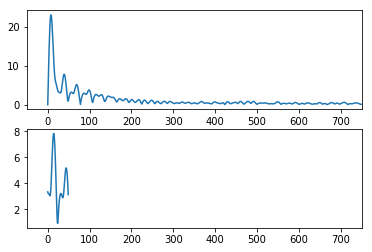

In [18]:
import matplotlib.pyplot as plt

idx = 0

#plt.suptitle("label: {}".format(train_X1['label'][idx][0]))
plt.subplot(2,1,1)
plt.xlim([-50, 750])
plt.plot(test_X[0][:])
plt.subplot(2,1,2)
plt.xlim([-50, 750])
plt.plot(test_X1[0][:])

plt.show()


# 4) SVM 분류기 학습 후 성능 평가하기

***Best parameters set found on development set***
{'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}

***Grid scores on development set***
0.876 (+/-0.118) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
0.876 (+/-0.118) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
0.876 (+/-0.118) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'linear'}
0.876 (+/-0.118) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.868 (+/-0.138) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'linear'}
0.876 (+/-0.127) for {'C': 10, 'gamma':

<Figure size 432x288 with 0 Axes>

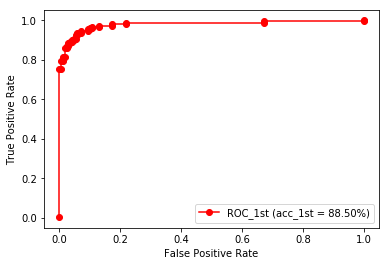

<Figure size 432x288 with 0 Axes>

In [36]:
import logging
import os
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## Train SVM classifier using grid-search
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['poly'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]

clf1 = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring='accuracy', n_jobs=-1)
clf1.fit(train_X1, train_y)

print("***Best parameters set found on development set***")
print(clf1.best_params_)
print()
print('==========')

print("***Grid scores on development set***")
means1 = clf1.cv_results_['mean_test_score']
stds1 = clf1.cv_results_['std_test_score']
for mean, std, params in zip(means1, stds1, clf1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
## Save the model
with open('svm_model1.p4', mode='wb') as f:
    pickle.dump(clf1, f, protocol=4)
    print("\n>> 'svm_model1.p4' is created!!\n")
    
print('==========')

# Evaluate the model
print("***Scores on evaluation sets***")
y_true1 = test_y
y_pred1 = clf1.predict(test_X1)

print(classification_report(y_true1, y_pred1))
confMat1 =  confusion_matrix(y_true1, y_pred1)

print('==========')
print(y_pred1)
print('==========')

#print('(', y_true, ') ,(', y_pred, ')')   # 실제, 위조 분류 결과 출력

tn1, fp1, fn1, tp1 = confusion_matrix(y_true1, y_pred1).ravel()

print("(tn, fp, fn, tp) = {}".format((tn1, fp1, fn1, tp1)))

print("True Negative = {}".format(tn1))
print("False Positive = {}".format(fp1))
print("False Negative = {}".format(fn1))
print("True Positive = {}".format(tp1))

Accuracy1 = ((tn1+tp1) / (tn1+fp1+fn1+tp1)) * 100.0
print("Accuracy1 = {}".format(Accuracy1))

hter1 = 0.5 * (fp1/(tn1+fp1) + fn1/(fn1+tp1))
print("HTER1 = {}".format(hter1))

precision1 = ((tp1) / (tp1 + fp1))
recall1 = ((tp1) / (tp1 + fn1))

print('==========')

# ROC curve
y_score1 = clf1.decision_function(test_X1)
y_true1 = test_y
fpr1, tpr1, _ = roc_curve(y_true1, y_score1, pos_label=1)
fnr1 = 1 - tpr1
roc_auc1 = roc_auc_score(y_true1, y_score1)

print('Finished!!'.center(50, '='))

print('==========')

# Plot the curve
plt.figure()
lw = 3

plt.plot(fpr1, tpr1, 'ro-', label='ROC_1st (acc_1st = %0.2f%%)' % Accuracy1)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.savefig('img.png')
plt.figure()
